## Incremental learning with River

In [85]:
from river import active
from river import datasets
import numpy as np
from river import feature_extraction
from river import linear_model
from sklearn.linear_model import LogisticRegression
from river import metrics
import sys
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
from predict import binarize
import os
from sklearn.neighbors import KNeighborsClassifier

In [86]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [87]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [89]:
# define hyperparameters
features_to_keep = 79
neighbors = 41

y_train = binarize(labels_train)
log_reg = LogisticRegression(C = 12.5) 
y_train = binarize(labels_train)
log_reg.fit(X_train, y_train)
sorted_feature_indices = np.argsort(log_reg.coef_[0])[::-1] # get the indices of the most important features in descending order

In [90]:
# dimensionality reduction (to stabilize KNN and avoid dimensionality curse)
indices = sorted_feature_indices[:features_to_keep]
X_train_top_feats = X_train[:, indices]

### Method 1: Entropy-sampling 

In [102]:
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics

# Prepare the data in a format compatible with river
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in X_train_top_feats
]
y_river = y_train.tolist()  # Converting to list for easier iteration

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression()
model = active.EntropySampler(base_model, discount_factor=100, seed=42)

n_samples_used = 0

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_one(x)  # x is now a dictionary
    metric = metric.update(y_true, y_pred)

    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

print(metric)
print(f"Number of samples used for learning: {n_samples_used}")

Accuracy: 97.98%
Number of samples used for learning: 59


#### Testing phase

In [103]:
X_test_top_f = X_test[:, indices]
y_test = binarize(labels_test)

In [104]:
X_river_test = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in X_test_top_f
]
y_river_test = y_test.tolist()  # Converting to list for easier iteration
metric = metrics.Accuracy()

# Process each sample in the dataset
for i in range(len(X_river_test)):
    x = X_river_test[i]
    y_true = y_river_test[i]
    y_pred, _ = model.predict_one(x)  # x is now a dictionary
    metric = metric.update(y_true, y_pred)

print(metric)

Accuracy: 97.06%


### Method 2: Anomaly detection using Gaussian scoring

In [368]:
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def gaussian_scorer_multi(y_values, window_size = 25, grace_period = 10, method = 0, plot = True):
    """
    Method: 0 if min of Gaussian anomaly scores for each variable, 1 if max of Gaussian anomaly scores, and 2 if product of scores, 3 if median of scores
    """
    from functools import reduce
    num_vals = y_values.shape[1]
    rng = random.Random(42)
    detectors = [anomaly.GaussianScorer(window_size=window_size, grace_period=grace_period) for el in range(num_vals)]
    anomaly_scores = [[] for el in range(num_vals)]

    for idx, detector in enumerate(detectors):
        for obs_idx, y in enumerate(y_values[:-1, idx]):
            detector = detector.learn_one(None, y) 
            anomaly_scores[idx].append(detector.score_one(None, y_values[obs_idx+1, idx]))

    anomaly_scores_np = [np.array(el) for el in anomaly_scores]
    result = np.minimum.reduce(anomaly_scores_np) if method == 0 else \
         np.maximum.reduce(anomaly_scores_np) if method == 1 else reduce(np.multiply, anomaly_scores_np) if method == 2 else np.median(np.vstack(anomaly_scores_np), axis=0)

    if plot:
        import matplotlib.pyplot as plt
        mnmx = StandardScaler()
        obs = np.arange(len(result))
        normalized_result = mnmx.fit_transform(result.reshape(-1, 1)).flatten()
        plt.bar(obs, normalized_result)
        plt.ylim(0, 1.15*max(normalized_result))
        string_method = "min_i" if method == 0 else "max_i" if method == 1 else "\prod_i" if method == 2 else "med_i"
        plt.xlabel('Observation (16,384 samples or 2.7 min per observation)')
        plt.ylabel('(Standardized) Gaussian anomaly score')
        plt.title(rf'Anomaly score: $score = 2\ {string_method} \|CDF(x_i) - 0.5\|$')

        plt.show()
    return result

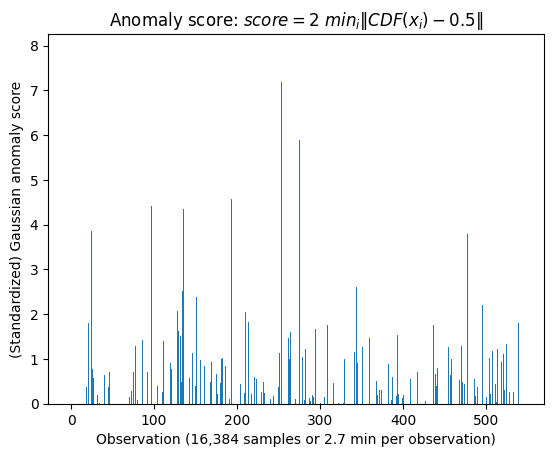

In [348]:
result = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20)

In [349]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 253)

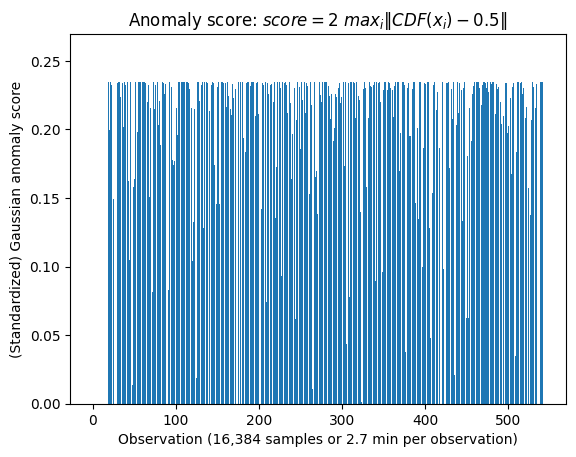

In [372]:
result = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20, method = 1) # max this time. REMARK: graph is very noisy. Taking a max is not a great idea

In [373]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 35)

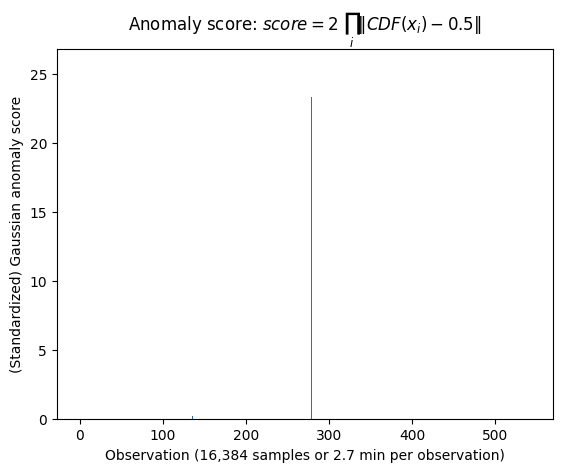

In [352]:
result = gaussian_scorer_multi(X_train_top_feats, window_size =45, grace_period = 20, method = 2) # product this time

In [353]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 2.1481348189988868e-16,
 279)

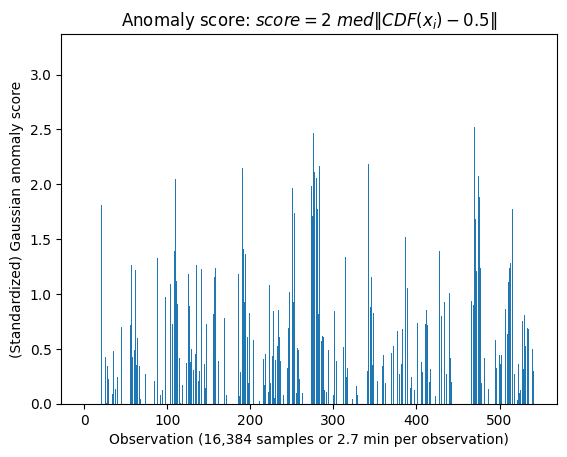

In [366]:
result = gaussian_scorer_multi(X_train_top_feats, window_size = 25, grace_period = 20, method = 3) # median this time

In [367]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 0.8758952139452798,
 279)

#### Supplementary: Example usage of RiverML on iris from Sklearn

In [79]:
"""
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics

# Load the iris dataset from sklearn
iris_sk = skdatasets.load_iris()

# Prepare the data in a format compatible with river
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in iris_sk['data']
]
y_river = iris_sk['target'].tolist()  # Converting to list for easier iteration

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression()
model = active.EntropySampler(base_model, seed=42)

n_samples_used = 0

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_one(x)  # x is now a dictionary
    metric = metric.update(y_true, y_pred)

    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

print(metric)
print(f"Number of samples used for learning: {n_samples_used}")
"""

'\nfrom sklearn import datasets as skdatasets  # Import to avoid naming conflicts\nfrom river import active\nfrom river import datasets\nfrom river import linear_model\nfrom river import metrics\n\n# Load the iris dataset from sklearn\niris_sk = skdatasets.load_iris()\n\n# Prepare the data in a format compatible with river\nX_river = [\n    {f"feature_{i}": value for i, value in enumerate(sample)}\n    for sample in iris_sk[\'data\']\n]\ny_river = iris_sk[\'target\'].tolist()  # Converting to list for easier iteration\n\nmetric = metrics.Accuracy()\nbase_model = linear_model.LogisticRegression()\nmodel = active.EntropySampler(base_model, seed=42)\n\nn_samples_used = 0\n\n# Process each sample in the dataset\nfor i in range(len(X_river)):\n    x = X_river[i]\n    y_true = y_river[i]\n    y_pred, ask = model.predict_one(x)  # x is now a dictionary\n    metric = metric.update(y_true, y_pred)\n\n    if ask:\n        n_samples_used += 1\n        model = model.learn_one(x, y_true)  # Learn f